In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
df = pd.read_excel('apps_event.xlsx')

In [6]:
df.head(4)

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,0.0,android,669460,female,Moscow,-
1,2020-01-01,app_start,0.0,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,0.0,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,0.0,android,1737182,female,Moscow,facebook_ads


In [7]:
df = df.fillna(0)

# DAU/WAU/MAU

In [9]:
df['date'] = pd.to_datetime(df['date'], format ="%Y.%m.%d")

In [10]:
df.head(4)

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,0.0,android,669460,female,Moscow,-
1,2020-01-01,app_start,0.0,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,0.0,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,0.0,android,1737182,female,Moscow,facebook_ads


In [11]:
df['visit_day'] = df['date'].dt.date
df['visit_week'] = df['date'].dt.week
df['visit_month'] = df['date'].dt.month
df['visit_year'] = df['date'].dt.year

<ipython-input-11-2b8b343f3c70>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['visit_week'] = df['date'].dt.week


In [12]:
#Сгруппируем данные по уникальным пользователям и найдём среднее для daily active users
dau_total = df.groupby('visit_day').agg({'device_id': 'nunique'}).mean().round()

In [13]:
dau_total

device_id    8576.0
dtype: float64

In [14]:
dau_total_by_day = df.groupby(['visit_day'], as_index=False).agg({'device_id': 'nunique'})
dau_total_by_day

,visit_day,device_id
0,2020-01-01,4445
1,2020-01-02,5104
2,2020-01-03,5144
3,2020-01-04,4925
4,2020-01-05,5608
5,2020-01-06,5165
6,2020-01-07,4774
7,2020-01-08,4951
8,2020-01-09,5417
9,2020-01-10,21431


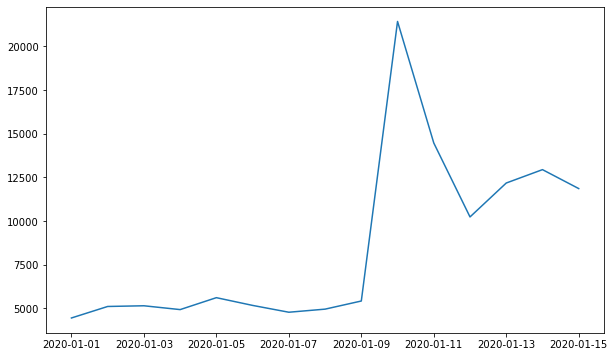

In [15]:
date = dau_total_by_day.visit_day
count = dau_total_by_day.device_id

fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.plot(date, 
        count)

In [16]:
wau_total = df.groupby(['visit_year', 'visit_week']).agg({'device_id': 'nunique'}).mean().round()
wau_total

device_id    27754.0
dtype: float64

In [17]:
wau_total = df.groupby(['visit_year', 'visit_week']).agg({'device_id': 'nunique'}).mean().round()
wau_total

device_id    27754.0
dtype: float64

In [18]:
mau_total = df.groupby('visit_month').agg({'device_id': 'nunique'}).mean()
mau_total

device_id    64372.0
dtype: float64

In [19]:
sticky_wau = (dau_total/wau_total) * 100
sticky_wau

device_id    30.90005
dtype: float64

In [1]:
sticky_mau = (dau_total/mau_total) * 100
sticky_mau

NameError: name 'dau_total' is not defined

In [20]:
sessions_per_user = df.groupby(['visit_day']).agg({'device_id':['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user

,n_sessions,n_users,sess_per_user
visit_day,,,
2020-01-01,15143,4445,3.406749
2020-01-02,17351,5104,3.399491
2020-01-03,17386,5144,3.379860
2020-01-04,16413,4925,3.332589
2020-01-05,19056,5608,3.398003
2020-01-06,17388,5165,3.366505
2020-01-07,16148,4774,3.382488
2020-01-08,16718,4951,3.376692
2020-01-09,18310,5417,3.380100


# ARPU

In [18]:
total_sum = df.purchase_sum.sum()
total_sum

20475977.5

In [24]:
uniq_users = df.device_id.nunique()
uniq_users

64372

In [35]:
ARPU = total_sum/uniq_users
ARPU

318.0882604237867

In [14]:
#посчитаем количество пользователей, у которых есть хотя бы одна покупка
users_pur = df.groupby('device_id', as_index = False).agg({'purchase_sum': 'sum'}).query("purchase_sum > 0").count()

In [15]:
users_pur = df.groupby('device_id', as_index = False).agg({'purchase_sum': 'sum'})

In [16]:
users_pur=users_pur.query("purchase_sum > 0").count()

In [17]:
users_pur

device_id       22858
purchase_sum    22858
dtype: int64

In [30]:
users_pur

device_id       22858
purchase_sum    22858
dtype: int64

In [19]:
ARPPU = total_sum/users_pur
ARPPU

device_id       895.790423
purchase_sum    895.790423
dtype: float64

# LTV

In [60]:
#Возьмём дату, когда пользователь впервые проявил активность
first_session_date_by_customers = df.groupby('device_id')['date'].min()
first_session_date_by_customers
first_session_date_by_customers.name = 'first_session_date'

In [61]:
visits = df.join(first_session_date_by_customers,on='device_id')
visits = df.join(first_session_date_by_customers,on='device_id')

In [62]:
cohorts = visits.groupby(['first_session_date','date']).agg({'purchase_sum': 'sum'}).reset_index()
cohorts.head()

,first_session_date,date,purchase_sum
0,2020-01-01,2020-01-01,592005.5
1,2020-01-01,2020-01-02,141907.5
2,2020-01-01,2020-01-03,172413.5
3,2020-01-01,2020-01-04,161714.5
4,2020-01-01,2020-01-05,162883.0


In [63]:
# Считаем количество новых покупателей за калждый месяц
cohort_sizes2 = visits.groupby('first_session_date').agg({'device_id': 'nunique'}).reset_index()
cohort_sizes2.columns = ['first_session_date', 'count_id']
print(cohort_sizes2.head()) 

  first_session_date  count_id
0         2020-01-01      4445
1         2020-01-02      3893
2         2020-01-03      2986
3         2020-01-04      2300
4         2020-01-05      2081


In [65]:
report = pd.merge(cohort_sizes2, cohorts, on='first_session_date')
report

,first_session_date,count_id,date,purchase_sum
0,2020-01-01,4445,2020-01-01,592005.5
1,2020-01-01,4445,2020-01-02,141907.5
2,2020-01-01,4445,2020-01-03,172413.5
3,2020-01-01,4445,2020-01-04,161714.5
4,2020-01-01,4445,2020-01-05,162883.0
...,...,...,...,...
115,2020-01-13,5619,2020-01-14,113694.0
116,2020-01-13,5619,2020-01-15,61755.5
117,2020-01-14,6415,2020-01-14,1406144.5
118,2020-01-14,6415,2020-01-15,156683.5


In [66]:
report.dtypes

first_session_date    datetime64[ns]
count_id                       int64
date                  datetime64[ns]
purchase_sum                 float64
dtype: object

In [70]:
report['ltv'] = report['purchase_sum'] / report['count_id']
report['age'] = report['date'] - report['first_session_date']

In [71]:
report

,first_session_date,count_id,date,purchase_sum,ltv,age
0,2020-01-01,4445,2020-01-01,592005.5,133.184589,0 days
1,2020-01-01,4445,2020-01-02,141907.5,31.925197,1 days
2,2020-01-01,4445,2020-01-03,172413.5,38.788189,2 days
3,2020-01-01,4445,2020-01-04,161714.5,36.381215,3 days
4,2020-01-01,4445,2020-01-05,162883.0,36.644094,4 days
...,...,...,...,...,...,...
115,2020-01-13,5619,2020-01-14,113694.0,20.233849,1 days
116,2020-01-13,5619,2020-01-15,61755.5,10.990479,2 days
117,2020-01-14,6415,2020-01-14,1406144.5,219.196337,0 days
118,2020-01-14,6415,2020-01-15,156683.5,24.424552,1 days


In [72]:
output = report.pivot_table(
        index='first_session_date', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)
    
output.fillna('') 

age,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,10 days,11 days,12 days,13 days,14 days
first_session_date,,,,,,,,,,,,,,,
2020-01-01,133.185,31.925,38.788,36.381,36.644,29.188,33.467,30.965,36.174,32.333,48.24,34.972,41.525,36.98,29.295
2020-01-02,133.767,34.822,23.617,35.028,34.314,24.35,22.942,20.109,35.782,33.424,27.29,33.757,21.81,25.946,
2020-01-03,172.540,24.595,31.626,20.688,21.455,22.012,19.748,28.473,23.703,23.473,29.508,17.913,17.601,,
2020-01-04,141.991,37.113,16.741,25.087,13.901,20.237,25.547,29.657,38.363,38.407,17.719,16.039,,,
2020-01-05,167.369,31.444,17.743,11.128,15.136,19.532,15.643,18.235,22.169,11.026,21.431,,,,
2020-01-06,155.431,19.391,17.306,24.15,22.898,22.153,28.031,18.758,17.98,17.795,,,,,
2020-01-07,192.401,20.51,20.422,19.199,15.452,10.577,12.157,9.624,11.237,,,,,,
2020-01-08,179.078,47.392,21.621,35.038,25.859,26.326,18.447,14.313,,,,,,,
2020-01-09,208.271,50.071,37.187,26.912,19.317,7.933,14.748,,,,,,,,


In [75]:
ltv_output = report.pivot_table(
index = 'first_session_date',
columns = 'age',
values = 'ltv',
aggfunc = 'mean')
ltv_output = ltv_output.cumsum(axis = 1)
ltv_output

age,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,10 days,11 days,12 days,13 days,14 days
first_session_date,,,,,,,,,,,,,,,
2020-01-01,133.184589,165.109786,203.897975,240.279190,276.923285,306.110911,339.577615,370.542857,406.716760,439.049719,487.289539,522.261755,563.786952,600.767154,630.06243
2020-01-02,133.767146,168.588877,192.205882,227.234138,261.548163,285.898407,308.840226,328.949653,364.731441,398.155407,425.445030,459.201901,481.011816,506.958258,NaN
2020-01-03,172.540188,197.135131,228.761052,249.448928,270.903717,292.915941,312.663932,341.137140,364.840589,388.313463,417.821165,435.734092,453.335566,NaN,NaN
2020-01-04,141.990652,179.104130,195.845217,220.931957,234.833261,255.070000,280.617174,310.273696,348.636522,387.043696,404.762826,420.801522,NaN,NaN,NaN
2020-01-05,167.368573,198.813071,216.556223,227.684286,242.819798,262.351514,277.994954,296.229938,318.399327,329.425517,350.856319,NaN,NaN,NaN,NaN
2020-01-06,155.431165,174.822222,192.128184,216.278320,239.176694,261.330081,289.361247,308.119512,326.100000,343.895122,NaN,NaN,NaN,NaN,NaN
2020-01-07,192.401148,212.911352,233.333546,252.532207,267.984375,278.561543,290.718431,300.342474,311.579082,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,179.078080,226.470272,248.091332,283.129656,308.988181,335.313754,353.760745,368.073782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,208.271437,258.342121,295.528679,322.440614,341.757532,349.690614,364.438586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
